# Integration of Heat PDE with Graph NN

In this notebook we propose to first generate data from numerical integration of a simple PDE : Heat equation. We first define the global parameters of the integration system, and the initial condition. Once we fix the boundary conditions, we can integrate the equation.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric
import networkx as nkx

%matplotlib notebook

## Global definitions

In [3]:
nx = 32
ny = 32

dx = 0.2
dy = 0.2

Lx= (nx-2)*dx
Ly= (ny-2)*dy

T=1.
dt= 0.1*dx**2

Dx= 1.
Dy= 1.

x = np.linspace(0, Lx, nx-1)
y = np.linspace(0, Ly, ny-1)

tplot = 0.05
nsteps = int(T/tplot)
tt = np.arange(nsteps)*tplot

## Initial Condition

In [4]:
def initialize(x,y, show=False):
    center = np.random.random(2,)
    xc = center[0] * Lx
    yc = center[1] * Ly
    
    xv, yv = np.meshgrid(x, y)
    CI = np.zeros((len(x)+1,len(y)+1))
    CI[1:,1:]=np.random.random(CI[1:,1:].shape)*0.04 + np.exp(-((xv-xc)**2)/5.) *  np.exp(-((yv-yc)**2)/5.) 
    if show:
        %matplotlib notebook 
        plt.pcolormesh(y, x, CI[1:-1,1:-1],vmin = 0, vmax=1, cmap='magma', label = 'risque')
        plt.show()
    return CI

def simulate(Dx, Dy, dt,dx, dy, T, tplot, CI, BC = 'Dirichlet', show=False):
    rt=[]
    r = CI.copy()
    rt.append(r.copy())
    if show:
        fig, (ax1) = plt.subplots(1,1,figsize=(5, 5))

        cax1 = ax1.pcolormesh(y, x, r[1:-1,1:-1],vmin = 0, vmax=1, cmap='magma', label = 'Temperature')
        ax1.set_title('Numerical Integration')

#        cax2 = ax2.pcolormesh(y, x, p[1:-1,1:-1],vmin = 0, vmax=1, cmap='Reds', label ='Temperature' )
#        ax2.set_title('GNN')

        fig.canvas.draw()

    n=0
    t=0
    i=0
    nt = int(T/dt)
    
    if BC == 'Dirichlet' :
        
        while i < nsteps:
            t0=t
            while n < nt and t - t0 <tplot:
                rn = r.copy()
                r[1:-1, 1:-1] = (rn[1:-1, 1:-1] +
                                 Dx * dt / dx ** 2 *
                                (rn[1:-1, 2:] - 2 * rn[1:-1, 1:-1] + rn[1:-1, 0:-2]) +
                                 Dy * dt / dy ** 2 *
                                 (rn[2:, 1: -1] - 2 * rn[1:-1, 1:-1] + rn[0:-2, 1:-1]))

                ### Dirichlet Boundary Conditions:

                r[0, :] = 0
                r[-1, :] = 0
                r[:, 0] = 0
                r[:, -1] = 0
                rt.append(r.copy())
                t += dt
                n += 1

            i += 1
            if show:
                cax1.set_array(r[1:-1,1:-1].ravel())
                #cax2.set_array(p[1:-1,1:-1].ravel())
                plt.pause(0.01)  # pause avec duree en secondes
                fig.canvas.draw()
        
    elif BC=='Cauchy':
        while i < nsteps:
            t0=t
            while n < nt and t - t0 <tplot:
                rn = r.copy()
                r[1:-1, 1:-1] = (rn[1:-1, 1:-1] +
                                 Dx * dt / dx ** 2 *
                                (rn[1:-1, 2:] - 2 * rn[1:-1, 1:-1] + rn[1:-1, 0:-2]) +
                                 Dy * dt / dy ** 2 *
                                 (rn[2:, 1: -1] - 2 * rn[1:-1, 1:-1] + rn[0:-2, 1:-1]))

                ### Cauchy Boundary Conditions

                r[0, :] = r[1, :]
                r[-1, :] = r[-2, :]
                r[:, 0] = r[:, 1]
                r[:, -1] = r[:, -2]

                rt.append(r.copy())
                t += dt
                n += 1

            i += 1
            if show:
                cax1.set_array(r[1:-1,1:-1].ravel())
                #cax2.set_array(p[1:-1,1:-1].ravel())
                plt.pause(0.01)  # pause avec duree en secondes
                fig.canvas.draw()     
   
    elif BC=='Periodic':
        while i < nsteps:
            t0=t
            while n < nt and t - t0 <tplot:
                rn = r.copy()
                r[1:-1, 1:-1] = (rn[1:-1, 1:-1] +
                                 Dx * dt / dx ** 2 *
                                (rn[1:-1, 2:] - 2 * rn[1:-1, 1:-1] + rn[1:-1, 0:-2]) +
                                 Dy * dt / dy ** 2 *
                                 (rn[2:, 1: -1] - 2 * rn[1:-1, 1:-1] + rn[0:-2, 1:-1]))

                ### Periodic Boundary Conditions

                r[0, :] = r[-2, :]
                r[-1, :] = r[1, :]
                r[:, 0] = r[:, -2]
                r[:, -1] = r[:, 1]
                rt.append(r.copy())

                t += dt
                n += 1

            i += 1
            if show:
                cax1.set_array(r[1:-1,1:-1].ravel())
                #cax2.set_array(p[1:-1,1:-1].ravel())
                plt.pause(0.01)  # pause avec duree en secondes
                fig.canvas.draw()     

    return np.array(rt)
           

           


<IPython.core.display.Javascript object>


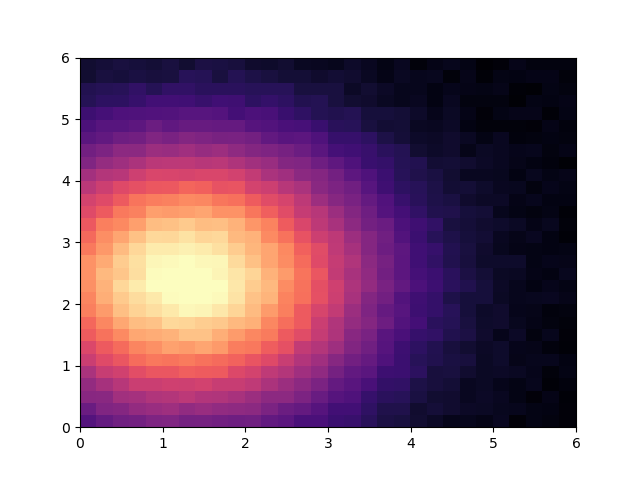

In [5]:
CI = initialize(x,y, show=True)

<IPython.core.display.Javascript object>


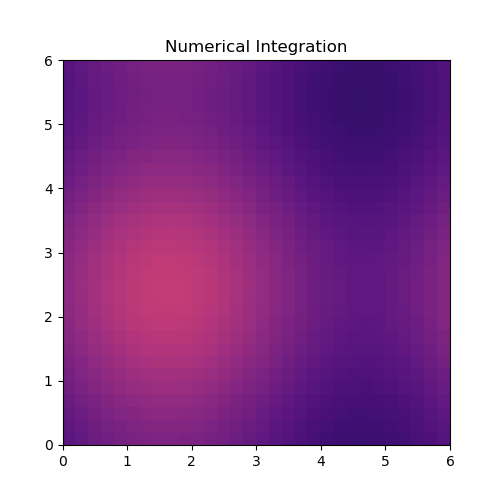

In [6]:
rt = simulate(Dx, Dy, dt,dx, dy, T, tplot, CI, BC = 'Periodic', show=True)

In [7]:
def tograph(arr):
    field_graph = nkx.grid_graph(dim=list(arr.shape))
    mapping = {pos: arr[pos[0],pos[1]] for pos in list(field_graph.nodes)}
    nkx.set_node_attributes(field_graph, mapping, 'value')
    return field_graph

def get_subgraph(graph, node_pos):
    subg_nodes = list(nkx.neighbors(graph,node_pos))
    subg_nodes.append(node_pos)
    return nkx.subgraph(graph, subg_nodes)

In [8]:
def show_graph(G):
    plt.figure(figsize=(6,6))
    pos = {(x,y):(y,x) for x,y in G.nodes()}
    ax = nkx.draw(G, pos=pos,
            cmap=plt.get_cmap('magma'),
            vmin=0,
            vmax=1,
            node_color=list(nkx.get_node_attributes(G, 'value').values()),
            with_labels=False,
            node_size=20)
    plt.show()

<IPython.core.display.Javascript object>


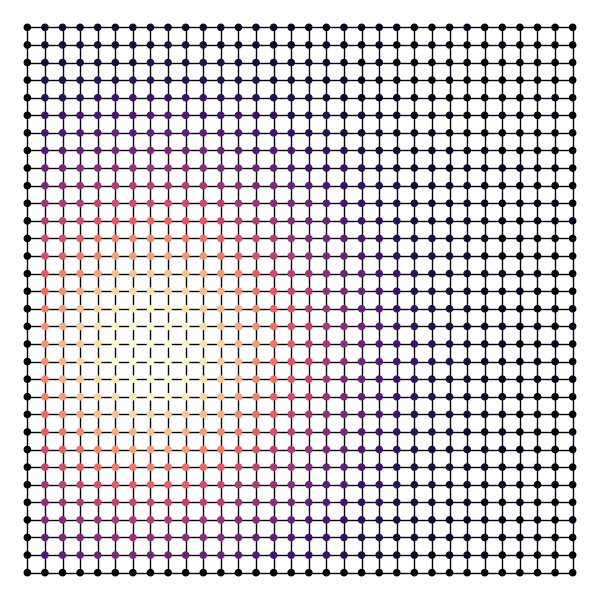

In [9]:
field_graph = tograph(rt[0])
show_graph(field_graph)

<IPython.core.display.Javascript object>


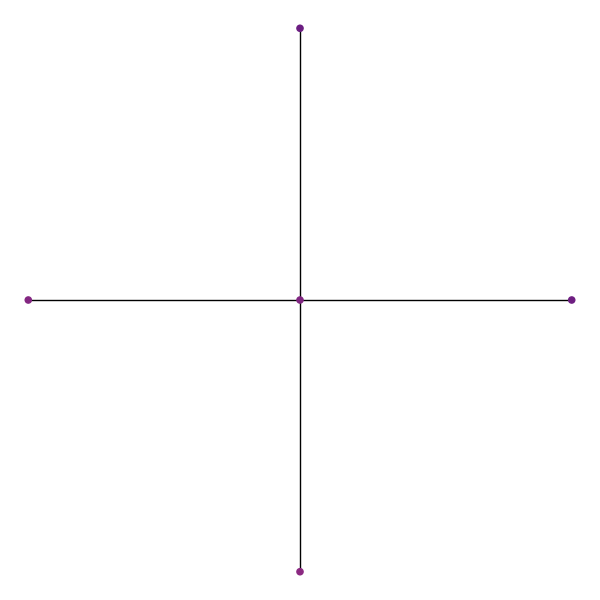

In [10]:
subg = get_subgraph(field_graph, (22,14))
show_graph(subg)

In [ ]:
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
import torch, torch_geometric
from torch_geometric.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool, DenseGCNConv
from tqdm import tqdm
from networkx import Graph

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## 1/ Build your model, prepare the data, and train the model

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ### Define the layers 
        
    def forward(self, data):
        ### Implement the GNN forward method
        
        return data

In [ ]:
model = Net()
### Define here the optimizer and loss

In [ ]:
# Create a dataloader : use the from_networkx method to define graph samples.
Data1= from_networkx(Graph({}))
Data2= from_networkx(Graph({}))

loader = DataLoader([Data1, Data2])

In [ ]:
# Train your model
model.train()
epochs = 20
for epoch in range(epochs):
    with tqdm(total=len(loader)) as pbar:
        for _, data in enumerate(loader):
            pbar.update(1)
            ####

## 2/ Evaluate your NN, and try to compare cumulative NN predictions with respect to the numerical integratino results.


## 3/ Try to see how the NN Generalizes to different initial conditions, different parameters, different boundary conditions ...
